# 1. Scraping text from a Kickstarter page

In [1]:
# Load required libraries
import nltk
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
from sklearn.externals import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Improve figure display
%matplotlib inline
sns.set(context='notebook', style='darkgrid')
sns.set(font_scale=1.3)

Select a test hyperlink.

In [2]:
hyperlink = 'https://www.kickstarter.com/projects/636921542/mobile-phone-cup-holder-dock-and-stand-apple-and-a?ref=category'

Scrape the HTML content from the website pointed by the hyperlink.

In [3]:
doc = requests.get(hyperlink)
soup = BeautifulSoup(doc.text, 'html.parser')

Replace all line break markers with a whitespace.

In [4]:
parsed_text = soup.get_text().replace('\n', ' ')

Define functions to extract information on the two main sections: *About This Project* and *Risks and Challenges*.

In [5]:
def extract_about_project(text):
    # Extracts the 'About this project' blurb
    return ''.join(re.findall(
        r'(?<=About this project).*(?=Risks and challenges)',
        text
    ))

In [6]:
def extract_risks(text):
    # Extracts the 'Risks and challenges' blurb
    return ''.join(re.findall(
        r'(?<=Risks and challenges).*(?=Learn about accountability on Kickstarter)',
        text
    ))

Define a function to clean up the extracted sections.

In [7]:
def clean_up(messy_text):    
    # Shrinks all whitespace to a single space
    clean_text = re.sub(r'\s+', ' ', messy_text)
    
    # Removes leading and trailing whitespace
    clean_text = re.sub(r'^\s+|\s+?$', '', clean_text)
    
    # Removes the video warning in the scraped content
    warning_str = "You'll need an HTML5 capable browser to see this content. Play Replay with sound Play with sound 00:00 00:00"
    return clean_text.replace(warning_str, '')

Test the above functions on `parsed_text`.

In [8]:
clean_up(extract_about_project(parsed_text))

'The first and only vehicle cup holder mobile phone dock and stand. This dock and stand is very easy to use with just one hand, no more getting in the vehicle and have to find your charging or syncing cord then plug in and put your phone on your seat or your lap only to have to turn sharply or break and your phone slides in the crevice of the seat or the floor, no more getting a call and cannot find your phone, with the mount you simply get in and drop your phone on the mount and it stays put and where you can always see the display, once docked the phone charges and connects to your stereo.'

In [9]:
clean_up(extract_risks(parsed_text))

'Only risks could be timing issues from obtaining parts.'

Test the extraction functions on a more lengthy Kickstarter page.

In [10]:
hyperlink = 'https://www.kickstarter.com/projects/sbf/sculpto-the-worlds-most-user-friendly-desktop-3d-p?ref=recommended'

In [11]:
doc = requests.get(hyperlink)
soup = BeautifulSoup(doc.text, 'html.parser')
parsed_text = soup.get_text().replace('\n', ' ')

In [12]:
about_project_text = clean_up(extract_about_project(parsed_text))
about_project_text

"3D printers are one of the coolest and most efficient ways for you to make your ideas go from the drawing board and into real life.Two years ago we launched a new type of 3D printer on Kickstarter. We wanted to make the amazing world of 3D printing available to everyone - not just engineers and tech-savvy people. We believe everyone should be able to bring their ideas to life. We started delivering that dream a year ago and opened a world of 3D printing for regular people and schools all over Denmark. Since then we have refined our production and software while developing Sculpto+The result is a small 3D printer with one of the biggest print areas seen on a plug'n'play printer. We have maximized printing performance while eliminating the noise and inconveniences of 3D printing - we have made the perfect desktop 3D printer. And the best part: Everyone can use it! Sculpto+ is a small 3D printer. It only weighs 2.7 KG and is about the size of your household coffeemaker, but has a printin

In [13]:
risks_text = clean_up(extract_risks(parsed_text))
risks_text

"The development of the Sculpto+ is almost finalized. Due to the fact that we are already manufacturing our previous Sculpto 3D printer - with a lot similarities to the Sculpto+ and have printers operating in private homes, schools and institutions all over Denmark we are very confident we can bring the Sculpto+ to production. The past 4 months we have been testing 3 stages of different prototypes and are now testing 10 production prototypes that are manufactured in a similar way to the final product. Our results have been amazing and we truly believe this 3D printer and the upgraded app will be a game-changer within 3D printing for consumers and educational use. Take a look at our 'prototype gallery' to see more. We have already started lining the production up and believe it is realistic to deliver all or a big part (Depending on the Kickstarters outcome) of the Sculpto+ 3D printers before Christmas."

# 2. Feature engineering

## Define functions to extract features

Count the number of sentences in the *About This Project* section.

In [14]:
def tokenize_sentences(text):
    # Tokenizes text into sentences and returns them in a list
    return nltk.sent_tokenize(text)

In [15]:
len(tokenize_sentences(about_project_text))

84

Count the number of all-caps words in the *About This Project* section.

In [16]:
def count_all_caps(text):
    # Counts the number of words in all-caps
    return len(re.findall(r'[A-Z]{2,}', text))

In [17]:
count_all_caps(about_project_text)

8

Count the number of exclamation points in the *About This Project* section.

In [18]:
def count_exclamations(text):
    # Counts the number of exclamation marks present in the text
    return len(re.findall(r'!', text))

In [19]:
count_exclamations(about_project_text)

5

Count the number of words in the *About This Project* section.

In [20]:
def remove_punc(text):
    # Returns the text with punctuation removed
    return re.sub(r'[^\w\d\s]', '', text)

In [21]:
def tokenize_words(text):
    # Tokenizes text into words and returns them in a list
    return nltk.word_tokenize(remove_punc(text))

In [22]:
len(tokenize_words(about_project_text))

1664

Count the number of words per sentence in the *About This Project* section.

In [23]:
def compute_avg_words(text):
    return pd.Series(
        [len(tokenize_words(sentence)) for sentence in \
         tokenize_sentences(text)]
    ).mean()

In [24]:
compute_avg_words(about_project_text)

19.80952380952381

## Create a master function for feature engineering

Using a list of hyperlinks, process each page, extract text sections, compute features, and store the results in a Pandas DataFrame.

In [25]:
# Initialize empty DataFrames
about_project_df = pd.DataFrame(
    columns=['num_sents', 'num_all_caps', 'num_exclms', 'num_words', 
             'avg_words_per_sent']
)

risks_df = pd.DataFrame(
    columns=['num_sents', 'num_all_caps', 'num_exclms', 'num_words', 
             'avg_words_per_sent']
)

Define a function to extract both sections given a hyperlink.

In [26]:
def extract_sections(hyperlink):
    # Scrape the HTML content from the website pointed by the hyperlink
    doc = requests.get(hyperlink)
    soup = BeautifulSoup(doc.text, 'html.parser')
    
    # Replace all line break markers with a whitespace
    parsed_text = soup.get_text().replace('\n', ' ')
    
    # Extract and clean up both sections
    return (
        clean_up(extract_about_project(parsed_text)), 
        clean_up(extract_risks(parsed_text))
    )

In [27]:
def extract_features(text):
    # Compute all features and return them in a list
    sentence_count = len(tokenize_sentences(text))
    all_caps_count = count_all_caps(text)
    exclm_count = count_exclamations(text)
    word_count = len(tokenize_words(text))
    avg_words = compute_avg_words(text)
    return [sentence_count, all_caps_count, exclm_count, word_count, avg_words]

## Demo day 1 

Load project data and converted `funded` column values into `string`.

In [28]:
df = joblib.load('extracted_data.pkl')
df['funded'] = df['funded'].apply(str)

Take a random sample of the scraped data and fix indices.

In [29]:
df_small = df.sample(100)
df_small = df_small.reset_index().drop('index', axis=1)

Perform web scraping and indicate % complete.

In [30]:
# Process text for each hyperlink and store features for each section in
# separate DataFrames
for index, row in df_small.iterrows():
    hyperlink = df_small.loc[index]['hyperlink']
    about_project_text, risks_text = extract_sections(hyperlink)
    about_project_df.loc[index] = extract_features(about_project_text)
    risks_df.loc[index] = extract_features(risks_text)
    if index % 10 == 0:
        print(index)

0
10
20
30
40
50
60
70
80
90


Combine scraped data with original DataFrame.

In [31]:
joined_about = pd.concat(
    (df_small[['name', 'funded']], about_project_df), axis=1
)

joined_risks = pd.concat(
    (df_small[['name', 'funded']], risks_df), axis=1
)

Serialize the scraped data.

In [34]:
joblib.dump(joined_about, 'scraped_about_project.pkl')
joblib.dump(joined_risks, 'scraped_risks.pkl')

['scraped_risks.pkl']

Visualize correlations and distributions in the features for the *About this Project* section.

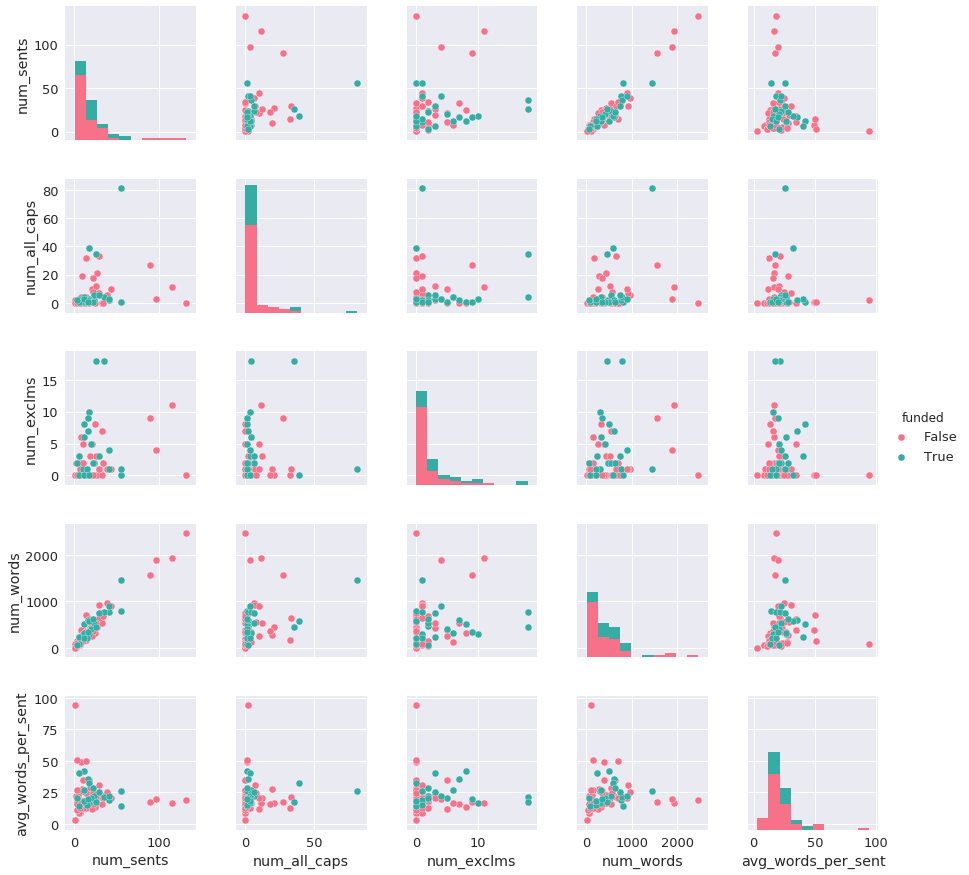

In [77]:
sns.pairplot(
    data=joined_about.dropna(),
    hue='funded',
    palette='husl'
);

Visualize correlations and distributions in the features for the *Risks and Challenges* section.

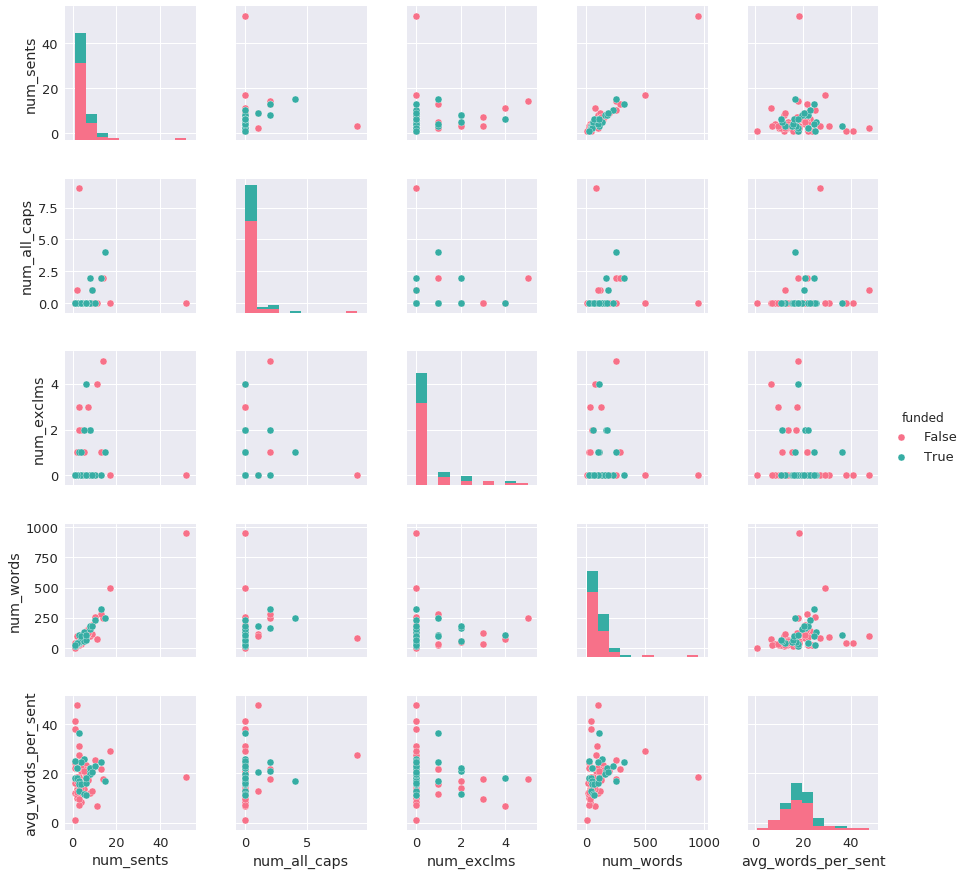

In [41]:
sns.pairplot(
    data=joined_risks.dropna(),
    hue='funded',
    palette='husl'
);